# Model training

## Load Python packages

In [1]:
#import tensorflow as tf
import numpy as np
#from tensorflow import keras
#from tensorflow.keras import layers
from scipy import stats
import session_info
#import tensorflow_probability as tfp
import pdb
from sklearn.metrics import r2_score
import shutil
import pandas as pd
import re
import os
from Bio.Seq import Seq
import gc
import matplotlib.pyplot as plt
import datetime
import socket
import time
import json
from collections import OrderedDict
import random as python_random

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor
from torch.nn.parameter import Parameter
import math
import pickle as pk
import sys

## Parameters

In [3]:
RUNTIME = 'none'
ARGS = {
  'model_id' : 'm20220727e',
  'global_seed' : 123,
  'shuffle_size' : 1000,
  'max_width' : 100,
  'head_len' : 17,
  'tail_len' : 13,
  'pct_ds' : 1, # % of total data for training/testing,
  'train_split' : 0.95,
  'alphabets' : {'A' : 0, 'C' : 1, 'G' : 2, 'T' : 3, 'N' : 4, 'M' : 5},
  'learning_rate' : 0.001,
  'initial_epoch': 0,
  'epochs' : 20,
  'batch_size' : 512,
  'dropout_rate' : 0.1,
  'kmer': 10,
  'strides' : 1,
  'embedding_dim' : 512,
  'num_heads' : 8,
  'ff_mult' : 4,
  'num_projectors' : 32,
  'n_blocks_regressor' : 4,
  'warmup_steps' : 12500, # ~ 1 epoch
  'mask_ratio' : 0.05,
  'remote_sample_submission_file' : 'https://raw.githubusercontent.com/de-Boer-Lab/DREAM-2022/main/sample_submission.json',
  'eval' : False,
  'device':'cuda:1'
}
if RUNTIME == 'msi':
  ARGS['remote_data_dir'] = 'https://s3.msi.umn.edu/gongx030/projects/dream_PGE/training_data/pct_ds=' + str(ARGS['pct_ds']) + '/'
  ARGS['local_data_dir'] = re.sub('https://', './', ARGS['remote_data_dir'])
  ARGS['remote_checkpoint_dir'] = 'https://s3.msi.umn.edu/gongx030/projects/dream_PGE/notebooks_msi/' + ARGS['model_id'] + '/tf_ckpts/'
  ARGS['remote_log_dir'] = 'https://s3.msi.umn.edu/gongx030/projects/dream_PGE/notebooks_msi/' + ARGS['model_id'] + '/log/'
  ARGS['local_checkpoint_dir'] = re.sub('https://', './', ARGS['remote_checkpoint_dir'])
  ARGS['local_log_dir'] = re.sub('https://', './', ARGS['remote_log_dir'])
  ARGS['remote_test_data'] = 'https://s3.msi.umn.edu/gongx030/projects/dream_PGE/test_sequences.txt.gz'
  ARGS['local_test_data'] = re.sub('https://', './', ARGS['remote_test_data'])
  ARGS['local_sample_submission_file'] = re.sub('https://', './', ARGS['remote_sample_submission_file'])
  ARGS['remote_prediction_file'] = 'https://s3.msi.umn.edu/gongx030/projects/dream_PGE/predictions/' + ARGS['model_id'] + '/pred.json'
  ARGS['local_prediction_file'] = re.sub('https://', './', ARGS['remote_prediction_file'])
  ARGS['s3_prediction_file'] = re.sub('https://s3.msi.umn.edu', 's3://', ARGS['remote_prediction_file'])
  ARGS['remote_prediction_tsv_file'] = 'https://s3.msi.umn.edu/gongx030/projects/dream_PGE/predictions/' + ARGS['model_id'] + '/pred.tsv'
  ARGS['local_prediction_tsv_file'] = re.sub('https://', './', ARGS['remote_prediction_tsv_file'])
  ARGS['s3_prediction_tsv_file'] = re.sub('https://s3.msi.umn.edu', 's3://', ARGS['remote_prediction_tsv_file'])
else:
  ARGS['local_data_dir'] = '/content/drive/MyDrive/training_data/pct_ds=' + str(ARGS['pct_ds']) + '/'
  ARGS['local_checkpoint_dir'] = '/content/drive/MyDrive/' + ARGS['model_id'] + '/tf_ckpts/'
  ARGS['local_log_dir'] = '/content/drive/MyDrive/' + ARGS['model_id'] + '/log/'

In [4]:
ARGS['local_data_dir'] = '/Data1/PGE/torch_ti/data/'

In [5]:
with open(ARGS['local_data_dir']+"data.pk","rb") as fr:
    data = pk.load(fr)

### Set seeds

In [6]:
# The below is necessary for starting Numpy generated random numbers
# in a well-defined initial state.
np.random.seed(ARGS['global_seed'])

# The below is necessary for starting core Python generated random numbers
# in a well-defined state.
#tf.random.set_seed(ARGS['global_seed'])
torch.manual_seed(ARGS['global_seed'])
# The below set_seed() will make random number generation
# in the TensorFlow backend have a well-defined initial state.
# For further details, see:
# https://www.tensorflow.org/api_docs/python/tf/random/set_seed
python_random.seed(ARGS['global_seed'])

In [28]:
#scc_loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True, reduction = 'none')
mse_loss = nn.MSELoss(reduction='none')
scc_loss = nn.CrossEntropyLoss( reduction='none')

### pearson_r

https://www.tutorialexample.com/implement-pearson-correlation-coefficient-loss-in-tensorflow-tensorflow-tutorial/

In [7]:
#def pearson_r(x, y):
  
#  mx = tf.reduce_mean(x, axis = 0, keepdims = True)
#  my = tf.reduce_mean(y, axis = 0, keepdims = True)
#  xm = x - mx
#  ym = y - my
#  t1_norm = tf.nn.l2_normalize(xm, axis = 0)
#  t2_norm = tf.nn.l2_normalize(ym, axis = 0)
#  return tf.reduce_sum(tf.multiply(t1_norm, t2_norm))
def pearson_r(x, y):
    x = torch.tensor(x,dtype=torch.float32)
    y = torch.tensor(y,dtype=torch.float32)
    mx = torch.mean(x, axis = 0, keepdims = True)
    my = torch.mean(y, axis = 0, keepdims = True)
    xm = x - mx
    ym = y - my
    t1_norm = F.normalize(xm, p=2, dim=0)
    t2_norm = F.normalize(ym, p=2, dim=0)
    return torch.sum(torch.mul(t1_norm, t2_norm))

In [9]:
x = np.random.rand(100)
y = np.random.rand(100)
print('pearson r (stats.pearsonr): {}'.format(stats.pearsonr(x, y)[0]))
#print('pearson r (pearson_r): {}'.format(pearson_r(tf.expand_dims(x, 1), tf.expand_dims(y, 1))))
print('pearson r (pearson_r): {}'.format(pearson_r(torch.unsqueeze(torch.Tensor(x),1), torch.unsqueeze(torch.Tensor(y),1))))

pearson r (stats.pearsonr): -0.09270195576139686
pearson r (pearson_r): -0.09270194172859192


/tmp/ipykernel_311/3244679858.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x,dtype=torch.float32)
/tmp/ipykernel_311/3244679858.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y,dtype=torch.float32)


### GLULayer

In [ ]:
class GLULayer(layers.Layer):
  def __init__(self, dim):
    super(GLULayer, self).__init__()
    self.dim = dim

  def call(self, x):
    out, gate = tf.split(x, 2, axis = self.dim)
    return out * tf.sigmoid(gate)

In [8]:
class GLULayer(nn.Module):
    def __init__(self, dim):
        super(GLULayer, self).__init__()
        self.dim = dim
        self.sig = nn.Sigmoid()

    def forward(self, x):
        out,gate = torch.chunk(x, 2, dim = self.dim)
        return out * self.sig(gate)

In [ ]:
#layer = GLULayer(dim = 2)
layer = GLULayer(dim = 1)
#x = tf.random.uniform([3, 10, 6])
x = torch.randn(3,6,10)
layer(x).shape

torch.Size([3, 3, 10])

### SwiGLU

In [ ]:
class SwiGLULayer(layers.Layer):
  def __init__(self, dim):
    super(SwiGLULayer, self).__init__()
    self.dim = dim
    self.swish = layers.Activation('swish')

  def call(self, x):
    out, gate = tf.split(x, 2, axis = self.dim)
    return out * self.swish(gate)

In [9]:

class SwiGLULayer(nn.Module):
    def __init__(self, dim):
        super(SwiGLULayer, self).__init__()
        self.dim = dim
        self.swish = nn.SiLU() # same as swish

    def forward(self, x):
        out, gate = torch.chunk(x, 2, dim = self.dim)
        return out * self.swish(gate)

In [ ]:
#layer = SwiGLULayer(dim = 2)
layer = SwiGLULayer(dim = 1)
#x = tf.random.uniform([3, 10, 6])
x = torch.randn(3,6,10)
layer(x).shape

torch.Size([3, 3, 10])

### FeedForwardSwiGLU

In [12]:
class FeedForwardSwiGLU(layers.Layer):
  def __init__(self, embedding_dim, mult=4, rate = 0.0, use_bias = False):
    super(FeedForwardSwiGLU, self).__init__()
    self.net = tf.keras.Sequential(
      [
        layers.LayerNormalization(epsilon = 1e-6),
        layers.Dense(embedding_dim * mult, use_bias = use_bias),
        SwiGLULayer(dim = 2),
        layers.Dropout(rate),
        layers.Dense(embedding_dim, use_bias = use_bias),
        layers.Dropout(rate),
      ]
    )

  def call(self, inputs):
    return self.net(inputs)



NameError: name 'layers' is not defined

In [10]:

class FeedForwardSwiGLU(nn.Module):
    def __init__(self, embedding_dim, mult=4, rate = 0.0, use_bias = False):
        super(FeedForwardSwiGLU, self).__init__()
        swiglu_out = int(embedding_dim * mult/2)
        self.layernorm = nn.LayerNorm(embedding_dim,eps = 1e-6)
        self.linear1 = nn.Linear(embedding_dim,embedding_dim * mult, bias = use_bias)
        self.swiglulayer = SwiGLULayer(dim = 1)
        self.drop = nn.Dropout(rate)
        self.linear2 = nn.Linear(swiglu_out,embedding_dim, bias = use_bias)

    def forward(self, inputs):
        x = self.layernorm(inputs.transpose(1,2)) # 차원바뀌고 채널 dim=2
        x = self.linear1(x) 
        x = self.swiglulayer(x.transpose(1,2)) # 또 차원 바뀌고 채널 dim =1
        x = self.drop(x)
        x = self.linear2(x.transpose(1,2)) # 차원 바뀌고 채널 dim=2
        out = self.drop(x.transpose(1,2)) # 차원 또 바뀌고 채널 dim =1
        return out

In [ ]:
ffn = FeedForwardSwiGLU(embedding_dim = 5, mult = 4)
#x = tf.random.uniform([3, 10, 5])
x = torch.randn(3,5,10)
print(ffn(x).shape)

torch.Size([3, 5, 10])


### CustomSchedule

In [28]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps

    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

NameError: name 'tf' is not defined

In [20]:
model = FeedForwardSwiGLU(embedding_dim = 5, mult = 4)
optimizer = torch.optim.SGD(model.parameters(), lr=0.0001)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.0014, pct_start = 0.125,
                                                steps_per_epoch=1, epochs=40000,anneal_strategy='cos')

In [15]:
d_model = 512
warmup_steps=12500
learning_rate = CustomSchedule(d_model)
temp_learning_rate_schedule = CustomSchedule(d_model, warmup_steps=4000)

In [26]:
optim = torch.optim.SGD(model.parameters(), lr=ARGS['learning_rate'])
scheduler = torch.optim.lr_scheduler.OneCycleLR(optim, max_lr=0.014, pct_start = 0.125,
                                                steps_per_epoch=1, epochs=ARGS['epochs'],anneal_strategy='cos')

Text(0.5, 1.0, 'CosineAnnealingWarmRestarts LR Scheduler')

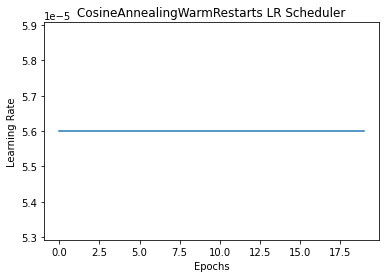

In [27]:
lrs  = []
for  i  in  range(20):
	scheduler.step()
	lrs.append(optimizer.param_groups[0]["lr"])  

plt.plot(lrs)
plt.xlabel("Epochs")
plt.ylabel("Learning Rate")
plt.title("CosineAnnealingWarmRestarts LR Scheduler")

Text(0.5, 0, 'Train Step')

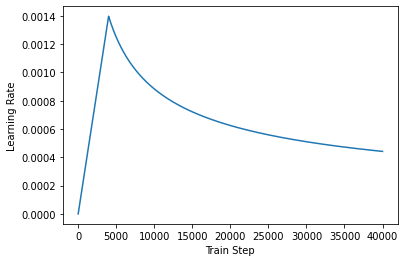

In [ ]:
#plt.plot(temp_learning_rate_schedule(tf.range(40000, dtype=tf.float32)))
#plt.ylabel('Learning Rate')
#plt.xlabel('Train Step')

### ConformerSASwiGLULayer

In [ ]:
class ConformerSASwiGLULayer(layers.Layer):
  def __init__(self, embedding_dim,  ff_mult = 4, kernel_size = 15, rate = 0.2, num_heads = 4, use_bias = False):
    super(ConformerSASwiGLULayer, self).__init__()
    self.ff1 = FeedForwardSwiGLU(embedding_dim = embedding_dim, mult = ff_mult, rate = rate, use_bias = use_bias)
    self.conv = tf.keras.Sequential([
      layers.LayerNormalization(epsilon = 1e-6),            
      layers.SeparableConv1D(filters = embedding_dim, kernel_size = kernel_size, padding = 'same', activation = 'relu'),
      layers.Dropout(rate),
    ])
    self.layernorm = layers.LayerNormalization(epsilon = 1e-6)        
    self.attn = layers.MultiHeadAttention(num_heads = num_heads, key_dim = embedding_dim)
    self.ff2 = FeedForwardSwiGLU(embedding_dim = embedding_dim, mult = ff_mult, rate = rate, use_bias = use_bias)

  def call(self, x):
    x = tf.cast(x, dtype = tf.dtypes.float32)
    x = x + 0.5 * self.ff1(x)
    x = x + self.conv(x)
    x = self.layernorm(x)
    x = x + self.attn(x, x)
    x = x + 0.5 * self.ff2(x)
    return x

In [11]:


class ConformerSASwiGLULayer(nn.Module):
    def __init__(self, embedding_dim,  ff_mult = 4, kernel_size = 15, rate = 0.2, num_heads = 4, use_bias = False):
        super(ConformerSASwiGLULayer, self).__init__()
        self.ff1 = FeedForwardSwiGLU(embedding_dim = embedding_dim, mult = ff_mult, rate = rate, use_bias = use_bias)
        self.layernorm1 = nn.LayerNorm(embedding_dim,eps = 1e-6)
        self.conv = nn.Sequential(   
          nn.Conv1d(in_channels=embedding_dim, out_channels=embedding_dim, kernel_size=kernel_size, groups=embedding_dim, padding='same'),
          nn.Conv1d(in_channels=embedding_dim, out_channels=embedding_dim, kernel_size=1, padding='same'),
          nn.ReLU(),
          nn.Dropout(rate),
        )
        self.layernorm2 = nn.LayerNorm(embedding_dim,eps = 1e-6)    
        self.attn = nn.MultiheadAttention(embed_dim=embedding_dim, num_heads=num_heads,batch_first=True)
        self.ff2 = FeedForwardSwiGLU(embedding_dim = embedding_dim, mult = ff_mult, rate = rate, use_bias = use_bias)

    def forward(self, x):
        x = x.float()
        x = x + 0.5 * self.ff1(x)
        x = self.layernorm1(x.transpose(1,2)) #채널 dim = 2
        x = x + self.conv(x.transpose(1, 2)).transpose(1, 2) # output 채널 dim = 2
        x = self.layernorm2(x)
        x = x + self.attn(x, x, x)[0]
        x = x.transpose(1,2) + 0.5 * self.ff2(x.transpose(1,2))
        return x

In [ ]:
layer = ConformerSASwiGLULayer(embedding_dim = 16)
#x = tf.random.uniform([3, 10, 14])
x = torch.randn(3,16,10)
print(layer(x).shape)

torch.Size([3, 16, 10])


### SequenceMaskLayer

In [14]:
class SequenceMaskLayer(layers.Layer):
  def __init__(self, n_positions, ratio = 0.2):
    super(SequenceMaskLayer, self).__init__()
    self.ratio = ratio
    self.n_positions = n_positions
    self.N = 4
    self.M = 5

  def call(self, x):

    if self.ratio > 0:
      m = tf.random.uniform(tf.shape(x)) < self.ratio
      m = tf.cast(m, dtype = tf.uint8)
      is_valid = tf.cast(tf.math.not_equal(x, self.N), tf.uint8)
      m = m * is_valid
      x0 = tf.ones(tf.shape(x), dtype = tf.uint8) * self.M

      x = m * x0 + (1 - m) * x
      m = tf.cast(m, dtype = tf.float32)
    else:
      m = tf.zeros(tf.shape(x))
    
    return x, m

NameError: name 'layers' is not defined

In [12]:
class SequenceMaskLayer(nn.Module):
    def __init__(self, n_positions, ratio = 0.2):
        super(SequenceMaskLayer, self).__init__()
        self.ratio = ratio
        self.n_positions = n_positions
        self.N = 4
        self.M = 5

    def forward(self, x):

        if self.ratio > 0:
            m = torch.rand(x.shape) < self.ratio
            m = m*1
            is_valid = x == self.N
            is_valid = is_valid * 1
            m = m * is_valid
            x0 = torch.ones(x.shape) * self.M

            x = m * x0 + (1 - m) * x
            m = m.float()
        else:
            m = torch.zeros(x.shape)
    
        return x, m

In [ ]:
ratio = 0.2
x1 = tf.random.uniform([3, 20], maxval = 5)
x = tf.cast(x1, tf.uint8)
print(x)
m1 = tf.random.uniform(tf.shape(x1)) < ratio
m = tf.cast(m1, dtype = tf.uint8)
N = 4
is_valid = tf.cast(tf.math.not_equal(x, N), tf.uint8)
print(tf.math.not_equal(x1, N))
print(is_valid)
print('*'*30)
x1 = torch.rand([3,20])*5
x = torch.floor(x1)
m1 = torch.rand(x1.shape) < ratio
m = m1*1
t = x == N
t = t*1
print(x)
print(t)



tf.Tensor(
[[2 2 3 1 0 0 1 4 2 1 3 3 1 4 1 2 4 4 0 2]
 [3 4 0 0 0 0 0 3 3 0 2 0 0 3 2 1 2 3 3 3]
 [2 4 4 0 1 4 3 4 0 0 1 2 1 1 2 3 1 1 2 2]], shape=(3, 20), dtype=uint8)
tf.Tensor(
[[ True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True  True  True  True  True]], shape=(3, 20), dtype=bool)
tf.Tensor(
[[1 1 1 1 1 1 1 0 1 1 1 1 1 0 1 1 0 0 1 1]
 [1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 0 0 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1]], shape=(3, 20), dtype=uint8)
******************************
tensor([[4., 4., 4., 4., 3., 1., 2., 4., 0., 2., 4., 3., 0., 3., 3., 4., 4., 2.,
         0., 3.],
        [0., 4., 2., 2., 4., 4., 0., 1., 1., 0., 4., 0., 1., 1., 3., 4., 1., 1.,
         3., 0.],
        [3., 2.,

In [ ]:
layer = SequenceMaskLayer(n_positions = 20, ratio = 0.2)
#x = tf.random.uniform([3, 20], maxval = 5)
x = torch.rand([3,20])*5
#x = tf.cast(x, tf.uint8)
x = torch.floor(x)
x, m = layer(x)
print(x)
print(m)

tensor([[4., 4., 0., 3., 2., 5., 0., 2., 3., 0., 2., 4., 0., 0., 1., 4., 4., 0.,
         2., 2.],
        [2., 0., 1., 3., 3., 1., 3., 4., 1., 3., 3., 0., 4., 4., 2., 3., 4., 2.,
         5., 1.],
        [2., 1., 4., 4., 0., 3., 0., 4., 3., 4., 0., 3., 2., 3., 1., 0., 0., 4.,
         3., 3.]])
tensor([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]])


## Read data

In [13]:
input_dim = int(6) # A,C,G,T,N,M
#input_dim = int(5) # A,C,G,T,N
n_positions = ARGS['max_width'] * 2

The tfdataset was prepraed by this notebook: https://github.com/ikwak2/dream_PGE/blob/main/notebooks/prepare_tfdatasets.ipynb

In [14]:
#ds = tf.data.experimental.load(ARGS['local_data_dir'])
#ds =data
#print(ds.keys())
#print(ds['seq'].shape)
#print(ds['expression'].shape)

In [15]:
#n = int(ds.cardinality())
n = int(len(data['seq']))
n_train = int(n * ARGS['train_split'])
print('downsampled dataset size: %d' % (n))
print('training dataset size: %d' % (n_train))

downsampled dataset size: 6737568
training dataset size: 6400689


In [ ]:
#ds = ds.shuffle(ARGS['shuffle_size'], seed = 1)

In [16]:
#train_ds = ds.take(n_train)
#test_ds = ds.skip(n_train)
train_data = {'seq':data['seq'][:n_train],'expression':data['expression'][:n_train]}
val_data = {'seq':data['seq'][n_train:],'expression':data['expression'][n_train:]}
#train_data = {'seq':data['seq'][:10000],'expression':data['expression'][:10000]}
#val_data = {'seq':data['seq'][10000:15000],'expression':data['expression'][10000:15000]}

print('# training samples: %d' % (len(train_data['seq'])))
print('# val samples: %d' % (len(val_data['seq'])))

# training samples: 6400689
# val samples: 336879


In [17]:
#train_ds = train_ds.batch(ARGS['batch_size'])
#test_ds = test_ds.batch(ARGS['batch_size'])

In [ ]:
#train_ds.element_spec

{'base': TensorSpec(shape=(None, 200), dtype=tf.uint8, name=None),
 'seq': TensorSpec(shape=(None, 200), dtype=tf.uint8, name=None),
 'expression': TensorSpec(shape=(None,), dtype=tf.float32, name=None)}

# DataLoader

In [17]:
class train_loader(object):
    def __init__(self, data):
        self.data = data['seq']
        self.data_label = data['expression']

    def __getitem__(self, index):

        return torch.FloatTensor(self.data[index]), self.data_label[index] 
    
    def __len__(self):
        return len(self.data)

class test_loader(object):
    def __init__(self):
        lines = open("/Data1/PGE/torch_ti/filtered_test_data_with_MAUDE_expression.txt", "r").read().splitlines()
        self.data = [x.split('\t')[0] for x in lines]
        self.data_label = [x.split('\t')[1] for x in lines]
       
    def __getitem__(self, index):

        return torch.FloatTensor(self.data[index]), self.data_label[index] 
    
    def __len__(self):
        return len(self.data)

## The regressor

In [ ]:
print(torch.arange(0, 10))

tensor([0, 1, 2, 0, 1, 2, 0, 1, 2, 0])


In [ ]:
a = torch.floor(torch.rand([16,200])*5)
print(a[:5,:5])
c = F.one_hot(torch.arange(0, 6).view(3,2) % 3)
print(c.shape)
print(a.dtype)
b = F.one_hot(a.to(torch.int64),5)
print(b.shape)

tensor([[1., 2., 4., 4., 4.],
        [2., 1., 1., 0., 4.],
        [2., 3., 0., 4., 2.],
        [2., 2., 3., 1., 0.],
        [0., 4., 4., 4., 4.]])
torch.Size([3, 2, 3])
torch.float32
torch.Size([16, 200, 5])


In [ ]:
x = tf.random.uniform([16, 200], maxval = 5)
#x = torch.rand([3,20])*5
x = tf.cast(x, tf.uint8)
x = tf.one_hot(x, 5)
print(x.shape)
x = tf.expand_dims(x, 2)
a = tf.image.extract_patches(images=x,
                           sizes=[1, 3, 1, 1],
                           strides=[1, 2, 1, 1],
                           rates=[1, 1, 1, 1],
                           padding='VALID')
print(a.shape)

(16, 200, 5)
(16, 99, 1, 15)


In [ ]:
A = torch.ones(2,3,10)
print(A)
PA = F.pad(A, (0,0,0,2), "constant", 0)
print(PA)
print(PA.shape)

tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]],

        [[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]])
tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]])
torch.Size([2, 5, 10])


In [ ]:
n = 10
  # images is a 1 x 10 x 10 x 1 array that contains the numbers 1 through 100
images = [[[[x * n + y + 1] for y in range(n)] for x in range(n)]]
i = torch.tensor(images).reshape(1,10,1,10)
print(i.shape)
print(i)
  # We generate two outputs as follows:
  # 1. 3x3 patches with stride length 5
  # 2. Same as above, but the rate is increased to 2
a = tf.image.extract_patches(images=i,
                           sizes=[1, 3, 1, 1],
                           strides=[1, 1, 1, 1],
                           rates=[1, 1, 1, 1],
                           padding = 'SAME')
d = F.pad(i.unfold(1,3,1).transpose(3,4),(0,0,0,0,0,0,1,1),'constant',0).reshape(i.shape[0],i.shape[1],i.shape[2],-1)
#print(i.unfold(1,3,1).transpose(3,4).shape)
#print(F.pad(i.unfold(1,3,1).transpose(3,4),(0,0,0,0,0,0,1,1),'constant',0).shape)
#print(i.unfold(1,3,1).transpose(3,4))
print(a)
print(a.shape)
print(d)
print(d.shape)

torch.Size([1, 10, 1, 10])
tensor([[[[  1,   2,   3,   4,   5,   6,   7,   8,   9,  10]],

         [[ 11,  12,  13,  14,  15,  16,  17,  18,  19,  20]],

         [[ 21,  22,  23,  24,  25,  26,  27,  28,  29,  30]],

         [[ 31,  32,  33,  34,  35,  36,  37,  38,  39,  40]],

         [[ 41,  42,  43,  44,  45,  46,  47,  48,  49,  50]],

         [[ 51,  52,  53,  54,  55,  56,  57,  58,  59,  60]],

         [[ 61,  62,  63,  64,  65,  66,  67,  68,  69,  70]],

         [[ 71,  72,  73,  74,  75,  76,  77,  78,  79,  80]],

         [[ 81,  82,  83,  84,  85,  86,  87,  88,  89,  90]],

         [[ 91,  92,  93,  94,  95,  96,  97,  98,  99, 100]]]])
tf.Tensor(
[[[[  0   0   0   0   0   0   0   0   0   0   1   2   3   4   5   6   7
      8   9  10  11  12  13  14  15  16  17  18  19  20]]

  [[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
     18  19  20  21  22  23  24  25  26  27  28  29  30]]

  [[ 11  12  13  14  15  16  17  18  19  20  21  22  23  24

In [ ]:
input_array = np.random.randint(1000, size=(32, 10))
print(input_array)

[[557 964 804 359 743 489 955 713 142 916]
 [801 725 725   8 665 844 757 401 768 790]
 [288 430  94 889 788 726 207  60 794 740]
 [446 101 691 447 653 868 430 774 331 667]
 [386 405 754 596 702 284 403 578 474 724]
 [872 416 605 559 358 808 122 648 687 485]
 [214 181 534 192 660 415 364 665  32 187]
 [904  80 581 941   6 127   6 632 740 964]
 [160 113 137 720 871 795 686 813 533 532]
 [765 366 183 287 159 370 675 414 837 821]
 [276  34 717  22 253 681 765 535 349 329]
 [836 382 636 762 425 669 710 389 199 819]
 [217 506 849 483 921 355 552 451 693 827]
 [844 950 919 374 862 126 213 423 465 703]
 [929 470  38 750 484 121 238 768 378 745]
 [531 622 664 133 115  93 467 968 631 880]
 [465 743 770 675 837 677  64  82 293 283]
 [942 968  46 254 521 343 473 967 132 908]
 [341 545 920 662 232 879 340 770 775 685]
 [241 957 678 818 230 789 812 202 662 432]
 [335 755 635 690 539 866 873 284 954 759]
 [869 709 752 845 220 496 509 923 969 621]
 [430 515 471 641 365  63 284 856  94 942]
 [237 526 1

In [18]:
class Regressor(nn.Module):
    def __init__(self, n_positions, kmer = 3, embedding_dim = 32, input_dim = 5, n_blocks = 4, 
               kernel_size =15, rate = 0.2, strides = 2, ratio = 0.2, num_heads = 4, ff_mult = 4, 
               use_bias = False, num_projectors = 8):
        super(Regressor, self).__init__()
        self.n_positions = int(n_positions / strides)
        self.input_dim = input_dim
        self.kmer = kmer
        self.strides = strides
        self.num_projectors = num_projectors
        self.n_blocks = n_blocks
        self.masking = SequenceMaskLayer(n_positions = n_positions, ratio = ratio)
        self.pos_embedding = nn.Embedding(self.n_positions, embedding_dim)
        self.strand_embedding = nn.Embedding(2, embedding_dim) # plus/minus strands
        self.expression_embedding = nn.Linear(1,embedding_dim)
        self.kmer_dense = nn.Linear(input_dim*self.kmer,embedding_dim)
        self.blocks = nn.ModuleList([ConformerSASwiGLULayer(embedding_dim = embedding_dim,
                                    kernel_size = kernel_size, rate = rate, num_heads = num_heads) for _ in range(n_blocks)])
        self.dropout = nn.Dropout(rate)
        self.expression_dense = nn.Linear(embedding_dim,1)
        self.nucleotide_dense = nn.Linear(embedding_dim,input_dim)

    def forward(self, x): # x = data['seq']

        batch_size = x.shape[0]

        x = F.one_hot(x.to(torch.int64), self.input_dim)   # b,seq,em

        x = x.unsqueeze(2)  # b,seq,1,em

     #   x = tf.image.extract_patches(x, sizes = [1, self.kmer, 1, 1], strides = [1, self.strides, 1, 1], 
     #                                rates = [1, 1, 1, 1], padding = 'SAME')

        #print(x.shape)
        x_shape = x.shape
        fold_shape = x.unfold(1,self.kmer,self.strides).transpose(3,4).shape
        div = x_shape[1] - fold_shape[1]
        x = F.pad(x.unfold(1,self.kmer,self.strides).transpose(3,4),(0,0,0,0,0,0,0,div),'constant',0).reshape(x.shape[0],x.shape[1]//self.strides,x.shape[2],-1)
        x = x.squeeze(2).float()
    #    print(x.shape)
    #    print(x.dtype)
        x = self.kmer_dense(x)

        pos = torch.arange(start=0, end = self.n_positions, step=1).cuda()
        pos = pos.unsqueeze(0)
        pos = self.pos_embedding(pos.long())

        strand = torch.tensor(np.repeat([0,1], repeats = int(self.n_positions / 2))).cuda()
        strand = strand.unsqueeze(0)
        strand = self.strand_embedding(strand.long())

        x = x + pos + strand  # 채널 dim=2

        expression = torch.zeros((batch_size, self.num_projectors, 1)).cuda()
        expression = self.expression_embedding(expression.float())

        x = torch.cat([expression, x], dim = 1)
        x = x.transpose(1,2)
        for i in range(self.n_blocks) :
            x = self.blocks[i](x)
        #x = self.blocks(x.transpose(1,2)).transpose(1,2)
        x = x.transpose(1,2)
    #    print('x : ',x.shape)
        expression = x[:,:self.num_projectors,:]
        x = x[:, -self.n_positions:, :]
    #    print('exp : ',expression.shape)
    #    print('x : ',x.shape)

        expression = self.dropout(expression)
        expression = self.expression_dense(expression)
        expression = torch.mean(expression, 1)

        x = self.nucleotide_dense(x)

        return expression, x.transpose(1,2)

In [20]:
a = torch.rand(4,3)
a = np.array([[1,2],[3,4]])
b = torch.mean(torch.tensor(a,dtype=torch.float32),dim=0)
print(b)
print(len(a.shape))

tensor([2., 3.])
2


In [19]:
'''
This part is used to train the speaker model and evaluate the performances
'''

from tqdm import tqdm

class RegressorModel(nn.Module):
	def __init__(self, args,**kwargs): # lr, lr_decay, C , n_class, m, s, test_step, **kwargs):
		super(RegressorModel, self).__init__()
		## regressor
		self.regressor = Regressor(n_positions = n_positions,embedding_dim = args['embedding_dim'],
                             n_blocks = args['n_blocks_regressor'],kmer = args['kmer'],input_dim = input_dim,
                             strides = args['strides'],ratio = args['mask_ratio'],num_heads = args['num_heads'],
                             rate = args['dropout_rate'],num_projectors = args['num_projectors']).cuda()
		## Classifier
		self.mse_loss = nn.MSELoss(reduction='none').cuda()
		self.scc_loss = nn.CrossEntropyLoss( reduction='none').cuda()
		self.optim           = torch.optim.Adam(self.regressor.parameters(), lr = args['learning_rate'], weight_decay = 2e-5)
		self.scheduler       = torch.optim.lr_scheduler.StepLR(self.optim, step_size = 1, gamma=0.95)
#		self.optim = torch.optim.SGD(self.regressor.parameters(), lr=args['learning_rate'])
#		self.scheduler = torch.optim.lr_scheduler.OneCycleLR(self.optim, max_lr=0.014, pct_start = 0.125,
#                                                steps_per_epoch=1, epochs=args['epochs'],anneal_strategy='cos')
		print(time.strftime("%m-%d %H:%M:%S") + " Model para number(백만) = %.2f"%(sum(param.numel() for param in self.regressor.parameters()) / 1024 / 1024))

	def train_network(self, epoch, loader):
		self.train()
		## Update the learning rate based on the current epcoh
		self.scheduler.step(epoch - 1)
		index, loss = 0, 0
		lr = self.optim.param_groups[0]['lr']
		for num, (data, labels) in tqdm(enumerate(loader, start = 1)):
			self.zero_grad()
			seq, mask = self.regressor.masking(data)
			labels = labels.cuda()
			expression, seq_pred = self.regressor.forward(data.cuda()) 
#			print(expression.dtype,seq_pred.dtype)
			loss_expression = self.mse_loss(labels.to(torch.float32), expression.squeeze(1).to(torch.float32))
			loss_seq = mask.cuda() * self.scc_loss(seq_pred,data.long().cuda())
			loss_seq = torch.sum(loss_seq) / (torch.sum(mask.cuda()) + 1)
			#print('seq_pred : ',seq_pred.shape,'data : ',data.shape)
			#print('loss_expression : ',loss_expression.to(torch.float32).dtype,'loss_seq : ',loss_seq.dtype)
#			print(loss_expression.shape,loss_seq.shape)
#			loss_expression = loss_expression.to(torch.float32)
			nloss = (loss_expression.to(torch.float32) + loss_seq.to(torch.float32)).mean().to(torch.float32)
#			print(nloss.dtype)
			
			nloss.backward()
			self.optim.step()
			index += len(labels)
			loss += nloss.detach().cpu().numpy()
			if num % 300 == 0 :
				sys.stderr.write(time.strftime("%m-%d %H:%M:%S") + \
				" [%2d] Lr: %5f, Training: %.2f%%, "    %(epoch, lr, 100 * (num / loader.__len__())) + \
				" Loss: %.5f \r"        %(loss/(num)))
				sys.stderr.flush()
				sys.stdout.write("\n")
		self.scheduler.step()
		return loss/num, lr 

	def eval_network(self, loader):
		self.eval()
		exp = []
		real_exp = []
		for idx, (data,labels) in tqdm(enumerate(loader)):
			# Full utterance
			data_1 = torch.FloatTensor(data).cuda()
			# Speaker embeddings
			with torch.no_grad():
				expression, _ = self.regressor.forward(data_1)
			if len(expression.shape) > 1 :
				expression = expression.reshape(-1)
				expression = expression.detach().cpu().numpy()
				labels = labels.detach().cpu().numpy() 
			exp.append(expression)
			real_exp.append(labels)
			
		# Coumpute Metric
		exp = np.array(exp).reshape(-1)
		real_exp = np.array(real_exp).reshape(-1)
		PR = pearson_r(exp, real_exp)

		return PR

	def save_parameters(self, path):
		torch.save(self.state_dict(), path)

	def load_parameters(self, path):
		self_state = self.state_dict()
		loaded_state = torch.load(path)
		for name, param in loaded_state.items():
			origname = name
			if name not in self_state:
				name = name.replace("module.", "")
				if name not in self_state:
					print("%s is not in the model."%origname)
					continue
			if self_state[name].size() != loaded_state[origname].size():
				print("Wrong parameter length: %s, model: %s, loaded: %s"%(origname, self_state[name].size(), loaded_state[origname].size()))
				continue
			self_state[name].copy_(param)

In [ ]:
loss = nn.CrossEntropyLoss(reduction='none')
inp  = torch.randn(4,5,200,requires_grad=True)
target = torch.empty(4,200,dtype=torch.long).random_(5)
output = loss(inp,target)
print(target[1,:5])
print(output.shape)

tensor([1, 0, 1, 3, 3])
torch.Size([4, 200])


In [32]:
class Regressor(keras.Model):
  def __init__(self, n_positions, kmer = 3, embedding_dim = 32, input_dim = 5, n_blocks = 4, 
               kernel_size =15, rate = 0.2, strides = 2, ratio = 0.2, num_heads = 4, 
               ff_mult = 4, use_bias = False, num_projectors = 8):
    super(Regressor, self).__init__()
    self.n_positions = int(n_positions / strides)
    self.input_dim = input_dim
    self.kmer = kmer
    self.strides = strides
    self.num_projectors = num_projectors
    self.n_blocks = n_blocks
    self.masking = SequenceMaskLayer(n_positions = n_positions, ratio = ratio)
    self.pos_embedding = layers.Embedding(self.n_positions, embedding_dim)
    self.strand_embedding = layers.Embedding(2, embedding_dim) # plus/minus strands
    self.expression_embedding = layers.Dense(embedding_dim)
    self.kmer_dense = layers.Dense(embedding_dim)
    self.blocks = keras.Sequential([ConformerSASwiGLULayer(embedding_dim = embedding_dim, kernel_size = kernel_size, rate = rate, num_heads = num_heads) for _ in range(n_blocks)])
    self.dropout = layers.Dropout(rate)
    self.expression_dense = layers.Dense(1)
    self.nucleotide_dense = layers.Dense(input_dim)

  def call(self, x):

    batch_size = tf.shape(x['seq'])[0]

    x = tf.one_hot(x['seq'], self.input_dim)

    x = tf.expand_dims(x, 2)
    x = tf.image.extract_patches(x, sizes = [1, self.kmer, 1, 1], strides = [1, self.strides, 1, 1], 
                                 rates = [1, 1, 1, 1], padding = 'SAME')
    x = tf.squeeze(x, 2)
    print(x)
    print(x.shape)
    x = self.kmer_dense(x)
    print(x.shape)
    pos = tf.range(start=0, limit=self.n_positions, delta=1)
    pos = tf.expand_dims(pos, 0)
    pos = self.pos_embedding(pos)

    strand = tf.repeat([0,1], repeats = int(self.n_positions / 2))
    strand = tf.expand_dims(strand, 0)
    strand = self.strand_embedding(strand)

    x = x + pos + strand

    expression = tf.zeros((batch_size, self.num_projectors, 1), dtype = tf.float32)
    expression = self.expression_embedding(expression)

    x = tf.concat([expression, x], axis = 1)
    x = self.blocks(x)

    expression = x[:,:self.num_projectors,:]
    x = x[:, -self.n_positions:, :]

    expression = self.dropout(expression)
    expression = self.expression_dense(expression)
    expression = tf.reduce_mean(expression, 1)

    x = self.nucleotide_dense(x)

    return expression, x

  def train_step(self, batch):

    seq, mask = self.masking(batch['seq'])
    
    with tf.GradientTape() as tape:
      expression, seq_pred = self({'seq' : seq})
      loss_expression = mse_loss(batch['expression'], expression)
      loss_expression = tf.reduce_mean(loss_expression)
      loss_seq = mask * scc_loss(batch['seq'], seq_pred)
      loss_seq = tf.reduce_sum(loss_seq) / (tf.reduce_sum(mask) + 1)
      loss = loss_expression + loss_seq

    gradients = tape.gradient(loss, self.trainable_variables)
    self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))

    self.compiled_metrics.update_state(batch['expression'], expression)
    res = {'loss' : loss, 'loss_seq' : loss_seq, 'loss_expression' : loss_expression}
    res.update({m.name: m.result() for m in self.metrics})
    return res

  def test_step(self, batch):
    expression, _ = self(batch)
    self.compiled_metrics.update_state(batch['expression'], expression)
    return {m.name: m.result() for m in self.metrics}

NameError: name 'keras' is not defined

In [ ]:
model = Regressor(embedding_dim = 12, n_positions = 120, kernel_size = 3, strides = 1, num_projectors = ARGS['num_projectors'])
#x = tf.random.uniform((3, 120), maxval = 5)
#x = tf.cast(x, dtype = tf.uint8)
x = torch.rand(3,120)*5
x = x.floor().long()
#expression_pred, x = model({'seq':x})
expression_pred, x = model(x)
print(expression_pred.shape)
print(x.shape)

torch.Size([3, 120, 15])
torch.float32
x :  torch.Size([3, 152, 12])
exp :  torch.Size([3, 32, 12])
x :  torch.Size([3, 120, 12])
torch.Size([3, 1])
torch.Size([3, 5, 120])


In [ ]:
#strategy = tf.distribute.MirroredStrategy()
#strategy = tf.distribute.experimental.CentralStorageStrategy()
#strategy = tf.distribute.experimental.MultiWorkerMirroredStrategy()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')


In [ ]:
#with strategy.scope():
#  model = Regressor(
#    n_positions = n_positions,
#    embedding_dim = ARGS['embedding_dim'], 
#    n_blocks = ARGS['n_blocks_regressor'],
#    kmer = ARGS['kmer'],
#    input_dim = input_dim,
#    strides = ARGS['strides'],
#    ratio = ARGS['mask_ratio'],
#    num_heads = ARGS['num_heads'],
#    rate = ARGS['dropout_rate'],
#    num_projectors = ARGS['num_projectors'],
#  )

In [ ]:
#learning_rate = CustomSchedule(ARGS['embedding_dim'], warmup_steps = ARGS['warmup_steps'])
#optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1 = 0.9, beta_2 = 0.98, epsilon=1e-9, clipnorm=1., clipvalue=0.5)

In [ ]:
#model.compile(
#  optimizer = optimizer,
#  metrics = [pearson_r],
#)

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


In [ ]:
#if ARGS['train_split'] < 1:
#  monitor = 'val_pearson_r'
#else:
#  monitor = 'pearson_r'

In [ ]:
#model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
#  filepath = ARGS['local_checkpoint_dir'],
#  save_weights_only = True,
#  monitor = monitor,
#  mode='max',
#  save_best_only = True,
#  save_freq = 'epoch',
#)

## Model fitting

### Epoch 1 

initial epoch: 1

In [ ]:
#if ARGS['train_split'] < 1:
#  model.fit(
#    train_ds,
#    validation_data = test_ds,
#    epochs = ARGS['epochs'],
#    callbacks = [model_checkpoint_callback],
#    initial_epoch = 1 - 1, 
#  )
#else:
#  model.fit(
#    train_ds,
#    epochs = ARGS['epochs'],
#    callbacks = [model_checkpoint_callback],
#    initial_epoch = 1 - 1, 
#  )


In [20]:
'''
This is the main code of the ECAPATDNN project, to define the parameters and build the construction
'''
torch.cuda.empty_cache()
import gc
gc.collect()
import argparse, glob, os, torch, warnings, time


model_save_path = "exps/model"
score_save_path = "exps/score2.txt"
os.makedirs(model_save_path,exist_ok = True)

device = ARGS['device']
torch.cuda.set_device(device)
print('Device:', device)
print('Current cuda device:', torch.cuda.current_device())


## Define the data loader
trainloader = train_loader(train_data)
trainLoader = torch.utils.data.DataLoader(trainloader, batch_size = ARGS['batch_size'], shuffle = True, num_workers = 0, drop_last = True)
valloader = train_loader(val_data)
valLoader = torch.utils.data.DataLoader(valloader, batch_size = ARGS['batch_size'], shuffle = True, num_workers = 0, drop_last = True)
testloader = test_loader()
testLoader = torch.utils.data.DataLoader(testloader, batch_size = ARGS['batch_size'], shuffle = True, num_workers = 0, drop_last = True)

## Search for the exist models
modelfiles = glob.glob('%s/model_0*.model'%model_save_path)
modelfiles.sort()

## Otherwise, system will try to start from the saved model&epoch
if len(modelfiles) >= 1:
	print("Model %s loaded from previous state!"%modelfiles[-1])
	epoch = int(os.path.splitext(os.path.basename(modelfiles[-1]))[0][6:]) + 1
	s = RegressorModel(ARGS)
	s.load_parameters(modelfiles[-1])
## Otherwise, system will train from scratch
else:
	epoch = 1
	s = RegressorModel(ARGS)

pr = []
eval_pr = []
score_file = open(score_save_path, "a+")

while(1):
	## Training for one epoch
	loss, lr = s.train_network(epoch = epoch, loader = trainLoader)

	## Evaluation every [test_step] epochs
	if epoch % 1 == 0:
		s.save_parameters(model_save_path + "/model_%04d.model"%epoch)
		pr.append(s.eval_network(valLoader))
		print(time.strftime("%Y-%m-%d %H:%M:%S"), "%d epoch, Pearson_R %2.2f%%, bestPearson_R %2.2f%%"%(epoch, pr[-1], max(pr)))
		score_file.write("%d epoch, LR %f, LOSS %f, Pearson_R %2.2f%%, bestPearson_R %2.2f%%\n"%(epoch, lr, loss, pr[-1], max(pr)))
		score_file.flush()
		if pr[-1] == max(pr) :
			s.save_parameters(model_save_path + "/model_best.model")
			eval_pr.append(s.eval_network(testLoader))
			print(time.strftime("%Y-%m-%d %H:%M:%S"), "%d epoch, Eval_Pearson_R %2.2f%%, Best_Eval_Pearson_R %2.2f%%"%(epoch, eval_pr[-1], max(eval_pr)))
			score_file.write("%d epoch, LR %f, LOSS %f, Pearson_R %2.2f%%, Best_Eval_Pearson_R %2.2f%%\n"%(epoch, lr, loss, eval_pr[-1], max(eval_pr)))
			score_file.flush()

	if epoch >= ARGS['epochs']:
		quit()

	epoch += 1


Device: cuda:1
Current cuda device: 1
Model exps/model/model_0001.model loaded from previous state!


/opt/conda/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:131: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
/opt/conda/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.

03-06 12:27:24 Model para number(백만) = 17.19


300it [09:23,  1.89s/it]03-06 12:36:48 [ 2] Lr: 0.000950, Training: 2.40%,  Loss: 32.09244 

600it [18:47,  1.87s/it]03-06 12:46:12 [ 2] Lr: 0.000950, Training: 4.80%,  Loss: 16.55126 

900it [28:07,  1.86s/it]03-06 12:55:32 [ 2] Lr: 0.000950, Training: 7.20%,  Loss: 11.37031 

1200it [37:26,  1.86s/it]03-06 13:04:51 [ 2] Lr: 0.000950, Training: 9.60%,  Loss: 8.78044 

1500it [46:44,  1.86s/it]03-06 13:14:09 [ 2] Lr: 0.000950, Training: 12.00%,  Loss: 7.22580 

1800it [56:00,  1.86s/it]03-06 13:23:25 [ 2] Lr: 0.000950, Training: 14.40%,  Loss: 6.18954 

2100it [1:05:17,  1.85s/it]03-06 13:32:42 [ 2] Lr: 0.000950, Training: 16.80%,  Loss: 5.44964 

2400it [1:14:33,  1.86s/it]03-06 13:41:58 [ 2] Lr: 0.000950, Training: 19.20%,  Loss: 4.89493 

2700it [1:23:50,  1.85s/it]03-06 13:51:15 [ 2] Lr: 0.000950, Training: 21.60%,  Loss: 4.46290 

3000it [1:33:04,  1.86s/it]03-06 14:00:29 [ 2] Lr: 0.000950, Training: 24.00%,  Loss: 4.11744 

3300it [1:42:21,  1.85s/it]03-06 14:09:46 [ 2] Lr: 0.000950, Training: 26.40%,  Loss: 3.83578 

3600it [1:51:34,  1.84s/it]03-06 14:18:59 [ 2] Lr: 0.000950, Training: 28.80%,  Loss: 3.59992 

3900it [2:00:49,  1.85s/it]03-06 14:28:14 [ 2] Lr: 0.000950, Training: 31.20%,  Loss: 3.39988 

4200it [2:10:04,  1.85s/it]03-06 14:37:29 [ 2] Lr: 0.000950, Training: 33.60%,  Loss: 3.22899 

4500it [2:19:19,  1.87s/it]03-06 14:46:44 [ 2] Lr: 0.000950, Training: 36.00%,  Loss: 3.08072 

4800it [2:28:37,  1.85s/it]03-06 14:56:02 [ 2] Lr: 0.000950, Training: 38.40%,  Loss: 2.95121 

5100it [2:37:53,  1.85s/it]03-06 15:05:18 [ 2] Lr: 0.000950, Training: 40.80%,  Loss: 2.83644 

5400it [2:47:10,  1.85s/it]03-06 15:14:34 [ 2] Lr: 0.000950, Training: 43.20%,  Loss: 2.73450 

5700it [2:56:26,  1.85s/it]03-06 15:23:51 [ 2] Lr: 0.000950, Training: 45.60%,  Loss: 2.64361 

6000it [3:05:42,  1.85s/it]03-06 15:33:06 [ 2] Lr: 0.000950, Training: 48.00%,  Loss: 2.56179 

6300it [3:14:58,  1.85s/it]03-06 15:42:23 [ 2] Lr: 0.000950, Training: 50.40%,  Loss: 2.60783 

6600it [3:24:14,  1.86s/it]03-06 15:51:39 [ 2] Lr: 0.000950, Training: 52.80%,  Loss: 2.53557 

6900it [3:33:30,  1.85s/it]03-06 16:00:55 [ 2] Lr: 0.000950, Training: 55.20%,  Loss: 2.46950 

7200it [3:42:46,  1.85s/it]03-06 16:10:10 [ 2] Lr: 0.000950, Training: 57.60%,  Loss: 2.40872 

7500it [3:52:02,  1.85s/it]03-06 16:19:27 [ 2] Lr: 0.000950, Training: 60.00%,  Loss: 2.35253 

7800it [4:01:18,  1.85s/it]03-06 16:28:43 [ 2] Lr: 0.000950, Training: 62.40%,  Loss: 2.30077 

8100it [4:10:34,  1.85s/it]03-06 16:37:58 [ 2] Lr: 0.000950, Training: 64.79%,  Loss: 2.25280 

8400it [4:19:50,  1.85s/it]03-06 16:47:15 [ 2] Lr: 0.000950, Training: 67.19%,  Loss: 2.20847 

8700it [4:29:06,  1.85s/it]03-06 16:56:31 [ 2] Lr: 0.000950, Training: 69.59%,  Loss: 2.16706 

9000it [4:38:22,  1.85s/it]03-06 17:05:46 [ 2] Lr: 0.000950, Training: 71.99%,  Loss: 2.12842 

9300it [4:47:38,  1.85s/it]03-06 17:15:03 [ 2] Lr: 0.000950, Training: 74.39%,  Loss: 2.09245 

9600it [4:56:54,  1.85s/it]03-06 17:24:19 [ 2] Lr: 0.000950, Training: 76.79%,  Loss: 2.05843 

9900it [5:06:10,  1.85s/it]03-06 17:33:35 [ 2] Lr: 0.000950, Training: 79.19%,  Loss: 2.02621 

10200it [5:15:29,  1.85s/it]03-06 17:42:54 [ 2] Lr: 0.000950, Training: 81.59%,  Loss: 1.99610 

10500it [5:24:47,  1.85s/it]03-06 17:52:12 [ 2] Lr: 0.000950, Training: 83.99%,  Loss: 1.96781 

10800it [5:34:03,  1.85s/it]03-06 18:01:28 [ 2] Lr: 0.000950, Training: 86.39%,  Loss: 1.94087 

11100it [5:43:20,  1.86s/it]03-06 18:10:45 [ 2] Lr: 0.000950, Training: 88.79%,  Loss: 1.91554 

11400it [5:52:37,  1.85s/it]03-06 18:20:02 [ 2] Lr: 0.000950, Training: 91.19%,  Loss: 1.89140 

11700it [6:01:53,  1.85s/it]03-06 18:29:18 [ 2] Lr: 0.000950, Training: 93.59%,  Loss: 1.86880 

12000it [6:11:09,  1.85s/it]03-06 18:38:34 [ 2] Lr: 0.000950, Training: 95.99%,  Loss: 1.84719 

12300it [6:20:25,  1.85s/it]03-06 18:47:50 [ 2] Lr: 0.000950, Training: 98.39%,  Loss: 1.82660 

12501it [6:26:39,  1.86s/it]
657it [06:25,  1.70it/s]


2023-03-06 19:00:29 2 epoch, Pearson_R -0.32%, bestPearson_R -0.32%


0it [00:00, ?it/s]


TypeError: new(): invalid data type 'str'

## Read testing data

In [ ]:
import os
os.system('wget -cx ' + ARGS['remote_test_data'])

NameError: ignored

In [ ]:
df = pd.read_csv(ARGS['local_test_data'], compression = 'gzip', sep = '\t', header = None)
df.columns = ['dna', 'expression']
df['dna'] = df['dna'].astype('string')
df['dna0'] = df['dna']
print('test dataset size: %d' % len(df))

test dataset size: 71103


min len: 110
max len: 110


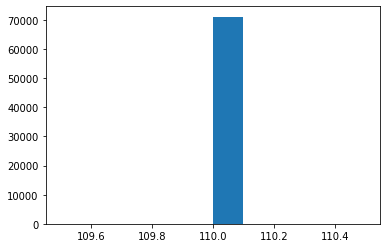

In [ ]:
df['len'] = df['dna'].str.len()
plt.hist(df['len'])
print('min len: {}'.format(df['len'].min()))
print('max len: {}'.format(df['len'].max()))

In [ ]:
print('number of unique sequences in the first {} positions: {}'.format(ARGS['head_len'], len(df['dna'].str[:ARGS['head_len']].unique())))
print('number of unique sequences in the last {} positions: {}'.format(ARGS['tail_len'], len(df['dna'].str[-ARGS['tail_len']:].unique())))

number of unique sequences in the first 17 positions: 1
number of unique sequences in the last 13 positions: 1


In [ ]:
df['dna'] = df['dna'].str[ARGS['head_len']:]
df['dna'] = df['dna'].str[:-ARGS['tail_len']]

min len: 80
max len: 80


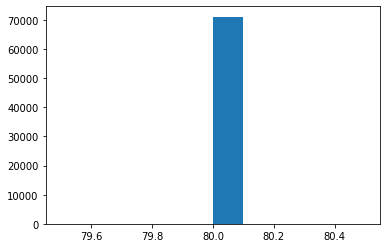

In [ ]:
df['len'] = df['dna'].str.len()
plt.hist(df['len'])
print('min len: {}'.format(df['len'].min()))
print('max len: {}'.format(df['len'].max()))

In [ ]:
assert all(df['len'] <= ARGS['max_width'])

In [ ]:
df['dna'] = df['dna'].str.pad(width = ARGS['max_width'], side = 'both', fillchar = 'N')
df['dna'] = df['dna'] + df['dna'].apply(lambda x: str(Seq(x).reverse_complement())).astype('string')

In [ ]:
#input_dim = int(5) # A,C,G,T,N
input_dim = int(6) # A,C,G,T,N,M
n_positions = ARGS['max_width'] * 2

In [ ]:
n_positions = int(ARGS['max_width'] * 2)
print('# positions=%d' % (n_positions))

# positions=200


In [ ]:
dna = np.empty((0, n_positions), np.uint8)
for x in np.array_split(df['dna'], 10): # split data into chunks
  y = np.array(x.apply(list))
  y = np.vstack(y)
  y = np.vectorize(ARGS['alphabets'].get)(y)
  y = y.astype(np.uint8)
  print(y.shape)
  dna = np.append(dna, y, axis = 0)

(7111, 200)
(7111, 200)
(7111, 200)
(7110, 200)
(7110, 200)
(7110, 200)
(7110, 200)
(7110, 200)
(7110, 200)
(7110, 200)


In [ ]:
base = np.zeros(dna.shape, dtype = np.uint8)
base[dna == 4] = 0 #
base[(dna == 0) | (dna == 2)] = 1 # A/G
base[(dna == 1) | (dna == 3)] = 2 # C/T

In [ ]:
ds = tf.data.Dataset.from_tensor_slices({
  'seq' : dna,
  'expression' : tf.zeros([len(df)]),
  'base' : base,
})
ds.element_spec

{'seq': TensorSpec(shape=(200,), dtype=tf.uint8, name=None),
 'expression': TensorSpec(shape=(), dtype=tf.float32, name=None),
 'base': TensorSpec(shape=(200,), dtype=tf.uint8, name=None)}

## Prediction

In [ ]:
model.load_weights(ARGS['local_checkpoint_dir'])

In [ ]:
expression = []
pbar = keras.utils.Progbar(len(ds.batch(ARGS['batch_size'])))
for step, batch in enumerate(ds.batch(ARGS['batch_size'])):
  pbar.update(step)
  expression_pred, _ = model(batch)
  expression.append(expression_pred)
expression = tf.concat(expression, axis = 0)

138/139 [============================>.] - ETA: 0s

In [ ]:
df['expression'] = expression.numpy()

In [ ]:
print('mean predicted expression: {}'.format(df['expression'].mean()))
print('std predicted expression: {}'.format(df['expression'].std()))

mean predicted expression: 0.29278337955474854
std predicted expression: 1.0623327493667603


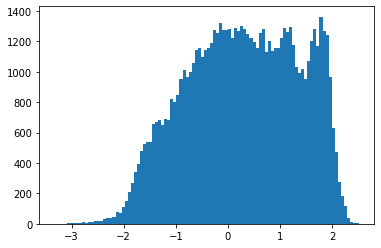

In [ ]:
p = plt.hist(df['expression'], bins = 100)

## Prepare submission file

In [ ]:
model.summary()

Model: "regressor_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequence_mask_layer_2 (Seque multiple                  0 (unused)
_________________________________________________________________
embedding_2 (Embedding)      multiple                  102400    
_________________________________________________________________
embedding_3 (Embedding)      multiple                  1024      
_________________________________________________________________
dense_26 (Dense)             multiple                  1024      
_________________________________________________________________
dense_27 (Dense)             multiple                  31232     
_________________________________________________________________
sequential_29 (Sequential)   (None, 232, 512)          47286272  
_________________________________________________________________
dropout_49 (Dropout)         multiple                  

Modified from https://github.com/de-Boer-Lab/DREAM-2022/blob/main/How%20to%20submit%20predictions%20to%20the%20public%20leaderboard.pdf

In [ ]:
os.system('wget -cx ' + ARGS['remote_sample_submission_file'])

--2022-08-07 17:32:22--  https://raw.githubusercontent.com/de-Boer-Lab/DREAM-2022/main/sample_submission.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 416 Range Not Satisfiable

    The file is already fully retrieved; nothing to do.



0

In [ ]:
with open(ARGS['local_sample_submission_file'], 'r') as f:
  ground = json.load(f)

In [ ]:
indices = np.array([int(indice) for indice in list(ground.keys())])

In [ ]:
PRED_DATA = OrderedDict()
Y_Pred = df['expression'].to_numpy()

In [ ]:
for i in indices:
  PRED_DATA[str(i)] = float(Y_Pred[i])

In [ ]:
local_prediction_dir = re.sub('(.+/)..+', '\\1', ARGS['local_prediction_file'])
if not os.path.exists(local_prediction_dir):
  os.makedirs(local_prediction_dir)
  print('creating {}'.format(local_prediction_dir))

In [ ]:
with open(ARGS['local_prediction_file'], 'w') as f:
  json.dump(PRED_DATA, f)
print('writing {}'.format(ARGS['local_prediction_file']))

writing ./s3.msi.umn.edu/gongx030/projects/dream_PGE/predictions/m20220727e/pred.json


Only if the notebook runs on MSI, otherwise, ignore this cell.

In [ ]:
!s3cmd sync {ARGS['local_prediction_file']} {ARGS['s3_prediction_file']}
!s3cmd setacl -P {ARGS['s3_prediction_file']}

In [ ]:
print('prediction file: {}'.format(ARGS['remote_prediction_file']))

prediction file: https://s3.msi.umn.edu/gongx030/projects/dream_PGE/predictions/m20220727e/pred.json


In [ ]:
df[['dna0', 'expression']].to_csv(ARGS['local_prediction_tsv_file'], header = False, sep = '\t', index = False)

In [ ]:
!s3cmd sync {ARGS['local_prediction_tsv_file']} {ARGS['s3_prediction_tsv_file']}
!s3cmd setacl -P {ARGS['s3_prediction_tsv_file']}

In [ ]:
print('prediction file(tsv): {}'.format(ARGS['remote_prediction_tsv_file']))

prediction file(tsv): https://s3.msi.umn.edu/gongx030/projects/dream_PGE/predictions/m20220727e/pred.tsv


# SessionInfo

In [ ]:
session_info.show()